Using the following dataset
https://www.kaggle.com/mostafafaramin/road-safety-data-accidents-2019
https://www.kaggle.com/daveianhickey/2000-16-traffic-flow-england-scotland-wales
https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data

In [1]:
# standard data exploration and manipulation package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import 
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.inspection import permutation_importance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot


/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# possible targets, time and day of week (create feature)
# can't really predict how many accients will happen on a day, because all the variables change per day and if they don't
# if they don't change everyday then there is nothing to train on

# road surface, carriageway_hazards, did_police officer attend scene, accident severity


def wrangle(fm_path):
    data = pd.read_csv(fm_path, parse_dates=['Date'], index_col='Date')
    
    # drop constant columns
    cols_to_drop = [col for col in data.select_dtypes('object') if data[col].nunique() == 1]
    data.drop(columns=cols_to_drop, inplace=True)

    # drop high cardinality categorical columns
    cols_to_drop = [col for col in data.select_dtypes('object') if data[col].nunique() > 500]
    data.drop(columns=cols_to_drop, inplace=True)    
    
    return data

In [3]:
DATA_PATH = './data/'
df = wrangle(DATA_PATH + 'Road Safety Data - Accidents 2019.csv')

In [4]:
df.head()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-18,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2,1,...,4202,0,5,1,1,1,0,0,1,3
2019-01-15,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,3,9,...,0,-1,-1,4,1,1,0,0,1,3
2019-01-01,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,3,2,...,0,0,0,4,1,1,0,0,1,1
2019-01-01,525531.0,184605.0,-0.191044,51.546387,1,2,1,1,3,2,...,510,0,0,4,1,1,0,0,1,1
2019-01-01,524920.0,184004.0,-0.200064,51.541121,1,3,2,2,3,28,...,0,0,0,4,1,1,0,0,1,1


In [5]:
target = 'Accident_Severity'
X = df.drop(columns=[target])
y = df[target]

In [6]:
# create X and y train and val splits
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.05, random_state = 42)


In [7]:
# baseline
# target classes are imbalanced
baseline_acc = y_train.value_counts(normalize=True).max()
baseline_acc

0.7859733653355305

In [8]:
model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingClassifier(random_state = 42)
)
model_boost.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Local_Authority_(Highway)'],
                                mapping=[{'col': 'Local_Authority_(Highway)',
                                          'data_type': dtype('O'),
                                          'mapping': E09000028      1
E10000013      2
E06000030      3
E10000019      4
E09000030      5
            ... 
S12000027    204
E06000017    205
S12000023    206
E06000053    207
NaN           -2
Length: 208, dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

In [9]:
print(f'boosting acc: {model_boost.score(X_train, y_train)}')

boosting acc: 0.7880332082501187


In [10]:
perm_imp = permutation_importance(model_boost, X_val, y_val, n_jobs = -1, random_state=42)

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.t

In [11]:
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']
        }

permutation_importances = pd.DataFrame(data, index = X_val.columns)
permutation_importances

,imp_mean,imp_std
Location_Easting_OSGR,0.000034,0.000330
Location_Northing_OSGR,0.011911,0.001715
Longitude,0.000987,0.000250
Latitude,0.000374,0.000250
Police_Force,0.000102,0.000512
Number_of_Vehicles,0.001531,0.000388
Number_of_Casualties,0.000306,0.000408
Day_of_Week,0.000034,0.000127
Local_Authority_(District),0.006058,0.001036
Local_Authority_(Highway),0.000306,0.000408


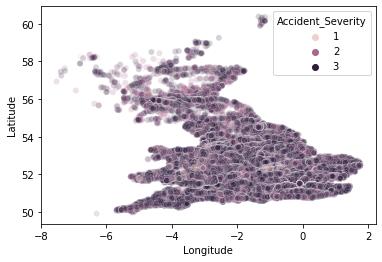

In [12]:
import seaborn as sns
sns.scatterplot('Longitude', 'Latitude', hue='Accident_Severity', data=df, alpha=.2)

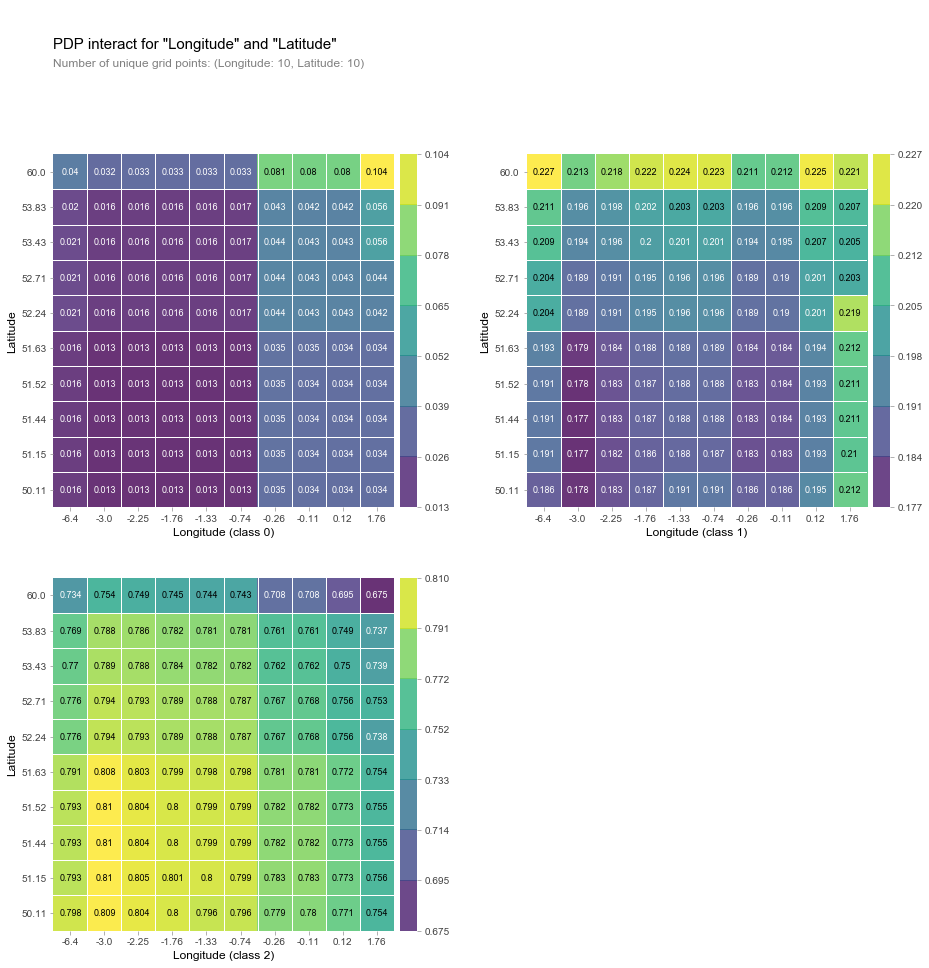

In [13]:
features = ['Longitude', 'Latitude']
# YOUR CODE HERE
plt.rcParams['figure.dpi'] = 72

interaction = pdp_interact(
    model=model_boost, 
    dataset=X_val.dropna(), 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names = features);